# Titanic


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from importlib import reload
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import optuna
import pickle
import seaborn as sns


from modules import function


In [9]:
# Get the raw data
train_raw = pd.read_csv("../data/raw/train.csv")
test_raw = pd.read_csv("../data/raw/test.csv")


In [10]:
train_raw.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train_raw.describe(include="O")

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
num_col = train_raw.dtypes[train_raw.dtypes != "O"].index
num_col

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [30]:
# Detect the outliers

def detect_outliers(df, num_col, threshold):
    """ Get the indecies of outliers based on the IQR method. 
    Note indecies cantain more than the threshold outliers.

    Args:
        df (_type_): _description_
        num_col (_type_): numeric columns
        threshold (_type_): threshold of the number of outliers

    Returns:
        _type_: indecies of the outliers to drop
    """
    
    outlier_indices = []
    for col in num_col:
        # Calculate the IQR, ignoring the nan
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1

        outlier_step = 1.5 * iqr

        outlier_list = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step)].index
        outlier_indices.extend(outlier_list)

    # Get the indices and the number as dict
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [idx for idx, num in outlier_indices.items() if num > threshold]
    
    return sorted(multiple_outliers)

df = train_raw
num_col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
threshold = 2

outlier_indices = detect_outliers(train_raw, num_col, threshold)


In [31]:
train_raw.loc[outlier_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.00,B22,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S


In [35]:
# Drop the outliers
train = train_raw.drop(index=outlier_indices).reset_index(drop=True)


In [44]:
dataset = pd.concat([train, test_raw], axis=0).reset_index(drop = True)

# Fill the missing values with nan
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

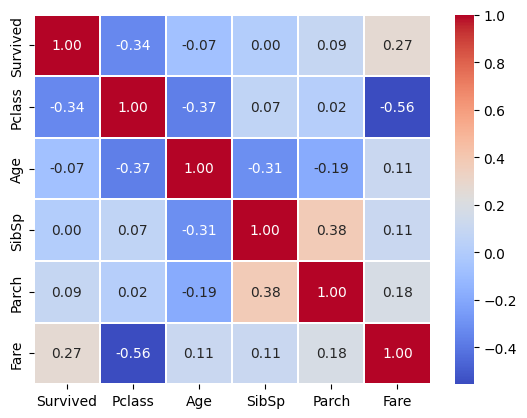

In [63]:
# Heatmap of the correlation of numeric columns
col = ["Survived" ,'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
corrmat = train[col].corr()
sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1);

In [65]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,880.000000,880.000000,880.000000,710.000000,880.000000,880.000000,880.000000
mean,446.373864,0.386364,2.309091,29.674887,0.454545,0.362500,31.076249
std,256.564211,0.487192,0.834364,14.479217,0.871872,0.791998,48.004681
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,225.750000,0.000000,2.000000,20.125000,0.000000,0.000000,7.895800
50%,447.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.427100
75%,667.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


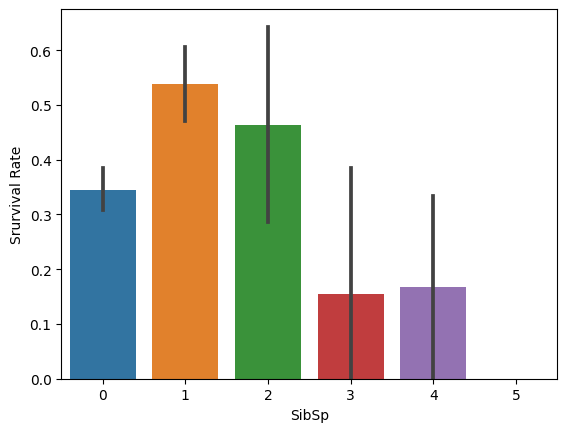

In [76]:
# SibSp
col = "SibSp"
sns.barplot(x=col, y="Survived", data=train)
plt.ylabel("Srurvival Rate");

/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Parch', ylabel='Survived'>

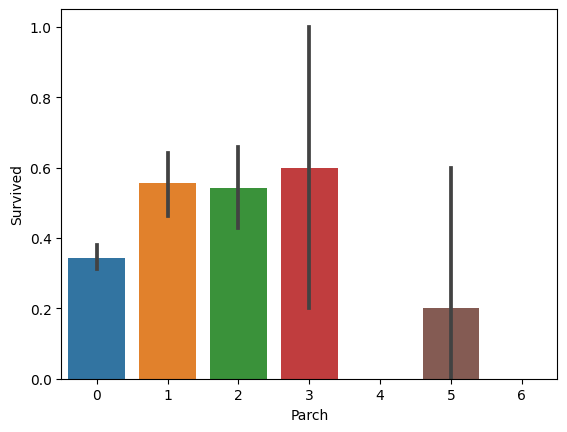

In [77]:
# Parch
sns.barplot(data=train, x="Parch", y="Survived")

/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_

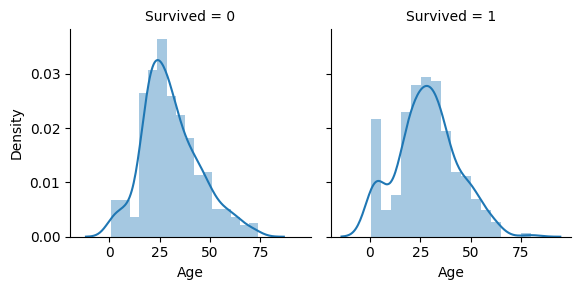

In [85]:
# Age
# 凡例ごとに分けてグラフを書くことができる　凡例＝Survived
g = sns.FacetGrid(train, col="Survived")
# Use map to draw it, using distplot
g = g.map(sns.distplot, "Age")

Skewness: 4.512689327210354


/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_55646/207958635.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["Fare"])
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

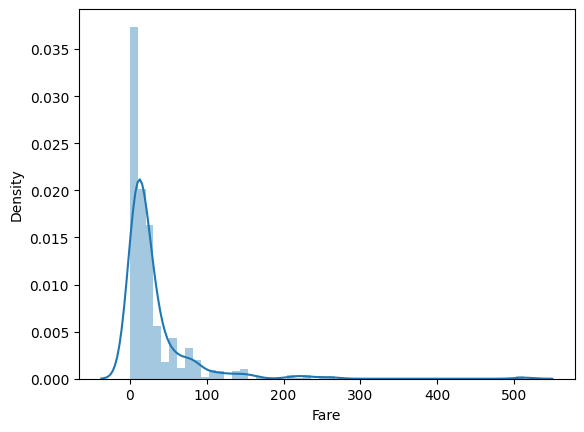

In [91]:
# Fare
sns.distplot(train["Fare"])
print("Skewness:",dataset["Fare"].skew())

In [93]:
dataset["Fare"] = np.log1p(dataset["Fare"])

Skewness: 0.5454503858334889


/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_55646/3133699810.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["Fare"])
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.optio

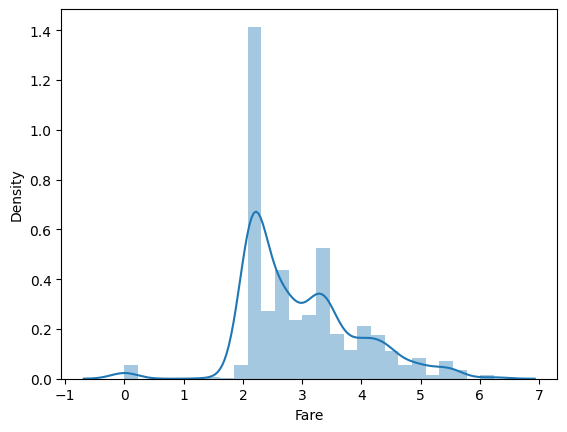

In [95]:
sns.distplot(dataset["Fare"])
print("Skewness:", dataset["Fare"].skew())

/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


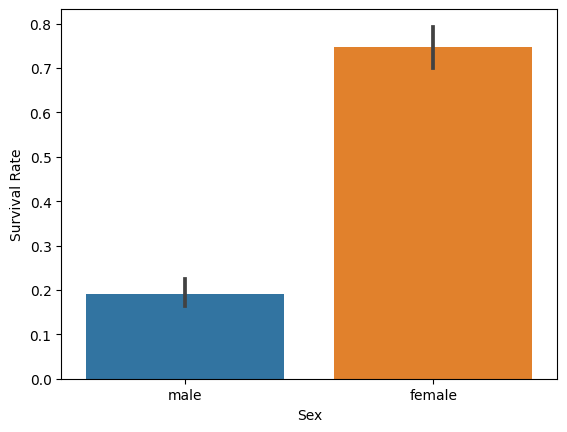

In [98]:
# Sex
sns.barplot(data=train, x="Sex", y="Survived");
plt.ylabel("Survival Rate");

In [104]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190893


/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

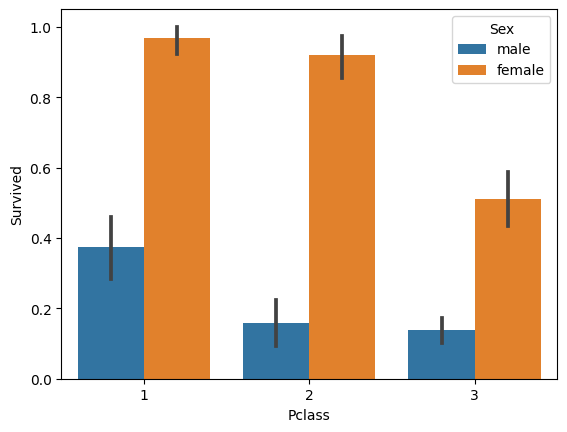

In [106]:
# Pclass
sns.barplot(data=train, x="Pclass", y="Survived", hue="Sex");

/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Embarked', ylabel='Survived'>

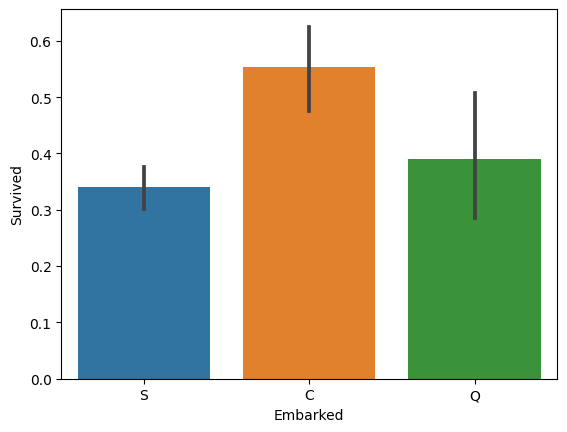

In [112]:
# Embarked
# The people from C have the highest survival rate
sns.barplot(data=train, x="Embarked", y="Survived")

/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/junya/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

<Axes: xlabel='Embarked', ylabel='count'>

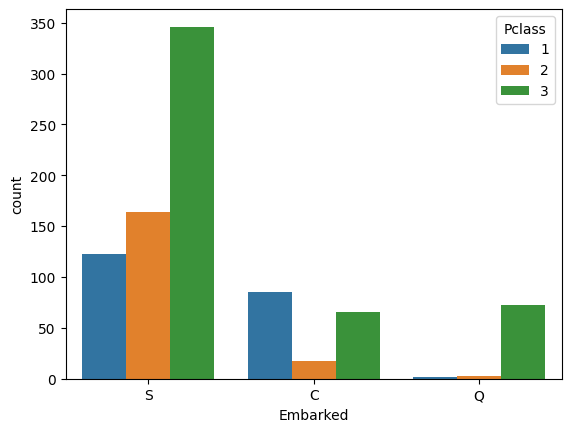

In [114]:
# The proportion of the 1st class is higher in C than in S and Q, so the survival rate is higher
sns.countplot(data=train, x="Embarked", hue="Pclass")

In [117]:
# Fill nan
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
# Fill nan with "S" the most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

In [54]:
# Get raw data
train_data_raw = pd.read_csv("../data/raw/train.csv")
test_data_raw = pd.read_csv("../data/raw/test.csv")

train_data_raw

# Extract used features
use_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]
y_train = train_data_raw["Survived"]
train_data = train_data_raw[use_columns]
test_data = test_data_raw[use_columns]

# Make one hot features of Sex and Embarked
for column_name in ["Sex", "Embarked"]:
    train_data = function.add_one_hot(train_data, column_name)
    test_data = function.add_one_hot(test_data, column_name)
    
# Replace nan to mean of the column
train_data = function.nan_to_mean(train_data)
test_data = function.nan_to_mean(test_data)


x_train = train_data
x_test = test_data
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()




# パラメータチューニング

In [ ]:
n_splits = 5
#　クロスバリデーション用
cv_cv = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=42)
#　最適化用
cv_opt = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=42)
#　探索範囲
params={"num_leaves":[2,30],"learning_rate":[0.01,0.2],"max_depth":[1,10]}
study_list = function.cv_lgbm_bayesian_opt(x_train, y_train, cv_cv, cv_opt, params, n_trials=100)

with open("../data/processed/study_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(study_list, p)


# モデル学習

In [55]:
with open("../data/processed/study_list_20230525_154947.bin", 'rb') as p:
    study_list = pickle.load(p)

best_pramas_list = []
for study in study_list:
    best_pramas_list.append(study.best_params)
    
#学習   
clf_list = function.cv_lgbm_clf(x_train, y_train, cv_cv, best_pramas_list, eval_metric="logloss", stopping_rounds=50)
with open("../models/clf_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(clf_list, p)

# 予測

In [56]:
# 多数決
with open("../models/clf_list_20230526_155950.bin", 'rb') as p:
    clf_list = pickle.load(p)

# 3以上なら1とする
sum_pred = np.zeros(len(x_test))
for clf in clf_list:
    sum_pred+=clf.predict(x_test)
y_pred = np.where(sum_pred >= 3, 1, 0)

# Save prediction
PassengerId = np.array(test_data_raw["PassengerId"]).astype(int)
function.save_kaggle_prediction(y_pred, PassengerId, "Survived", "PassengerId")

In [ ]:


x_label = "Age"
y_label = "Fare"
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(train_data_raw[x_label], train_data_raw[y_label], c=train_data_raw["Survived"], cmap='viridis')

# 軸ラベルの設定
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

# 凡例の表示
legend_labels = ['Dead', 'Survived']
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')
